In [1]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [2]:
import pandas as pd
import numpy as np

path = "../data/house_prices/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [3]:
from fastai import *
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [4]:
from utils.models import CatBoostCV, LGBMCV, FastAICV
from utils.eda import reduce_mem_usage, missing_data, get_cats_nums

In [5]:
train.columns = [f.lower() for f in train.columns]
test.columns = [f.lower() for f in test.columns]

In [6]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive

In [8]:
missing_data(train)

,Total,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
...,...,...
centralair,0,0.000000
salecondition,0,0.000000
heating,0,0.000000
totalbsmtsf,0,0.000000


In [9]:
missing_data(test)

,Total,Percent
poolqc,1456,99.794380
miscfeature,1408,96.504455
alley,1352,92.666210
fence,1169,80.123372
fireplacequ,730,50.034270
...,...,...
electrical,0,0.000000
centralair,0,0.000000
heatingqc,0,0.000000
foundation,0,0.000000


# Drop columns that 90% is missing

In [10]:
miss = missing_data(train)

In [11]:
drop_cols = miss.loc[miss['Percent'] > 90.].index.tolist()

In [12]:
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [13]:
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,3ssnporch,screenporch,poolarea,fence,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


# Let's just impute right away for the sake of demo.

In [14]:
unused_cols = ['id', 'saleprice']

In [15]:
cats, nums = get_cats_nums(train)

In [16]:
for cat in cats: #lowercase all strings to avoid case sensitivity
    train[cat] = train[cat].str.lower()
    test[cat] = test[cat].str.lower()

In [17]:
nums = [f for f in nums if f not in unused_cols]

In [18]:
import gc; gc.enable()
# for cat in cats:
#     impute_value = train[cat].mode()[0]
#     train[cat] = train[cat].fillna(impute_value)
#     test[cat] = test[cat].fillna(impute_value)
#     del impute_value; gc.collect()

In [19]:
for num in nums:
    impute_value = train[num].mean()
    train[num] = train[num].fillna(impute_value)
    test[num] = test[num].fillna(impute_value)

In [20]:
feats = cats + nums

In [21]:
feats

['mszoning',
 'street',
 'lotshape',
 'landcontour',
 'utilities',
 'lotconfig',
 'landslope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldgtype',
 'housestyle',
 'roofstyle',
 'roofmatl',
 'exterior1st',
 'exterior2nd',
 'masvnrtype',
 'exterqual',
 'extercond',
 'foundation',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'heating',
 'heatingqc',
 'centralair',
 'electrical',
 'kitchenqual',
 'functional',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'paveddrive',
 'fence',
 'saletype',
 'salecondition',
 'mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 '1stflrsf',
 '2ndflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'woo

In [22]:
train['saleprice'].min(), train['saleprice'].max()

(34900, 755000)

In [23]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of properties dataframe is : 0.86895751953125  MB
******************************
Column:  id
dtype before:  int64
min for this col:  1
max for this col:  1460
dtype after:  uint16
******************************
******************************
Column:  mssubclass
dtype before:  int64
min for this col:  20
max for this col:  190
dtype after:  uint8
******************************
******************************
Column:  lotfrontage
dtype before:  float64
min for this col:  21.0
max for this col:  313.0
dtype after:  float32
******************************
******************************
Column:  lotarea
dtype before:  int64
min for this col:  1300
max for this col:  215245
dtype after:  uint32
******************************
******************************
Column:  overallqual
dtype before:  int64
min for this col:  1
max for this col:  10
dtype after:  uint8
******************************
******************************
Column:  overallcond
dtype before:  int64
min for this col:  1

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = KFold(n_splits=3, shuffle=True, random_state=13)
kf_splitted = kf.split(train[feats], train.saleprice)

In [25]:
kf_folds = []
for tr, te in kf_splitted:
    kf_folds.append([tr, te])

In [26]:
procs=[FillMissing, Categorify, Normalize]
bs=64

In [27]:
fastai_model = FastAICV(
    folds=kf_folds, cat_names=cats, obj='regression', cont_names=nums,\
    procs=procs, metric=root_mean_squared_error, metric_mode='min',
    bs=bs
)

In [28]:
train[cats] = train[cats].astype('category')
test[cats] = test[cats].astype('category')

In [29]:
##define architecture

layers = [250, 100]
ps=[0.001, 0.01]
emb_drop=0.04

In [30]:
fastai_model.fit_predict(train, test, epochs=50, lr=1e-2, wd=0.001, y='saleprice',\
               layers=layers, ps=ps, emb_drop=emb_drop)

In [31]:
cv_score = np.mean(fastai_model.model_scores_); cv_score

0.15125643

In [32]:
pd.read_csv(path+"sample_submission.csv")

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [33]:
test['SalePrice'] = fastai_model.predict()

In [34]:
test['SalePrice'] = np.exp(test['SalePrice']) #back to its original state

In [35]:
train['saleprice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: saleprice, Length: 1460, dtype: uint32

In [36]:
test['SalePrice']

0       116530.853823
1       152700.316949
2       181598.126733
3       190962.189971
4       199934.684544
            ...      
1454     91060.154148
1455     88109.112514
1456    176727.521740
1457    124150.714205
1458    214920.553408
Name: SalePrice, Length: 1459, dtype: float64

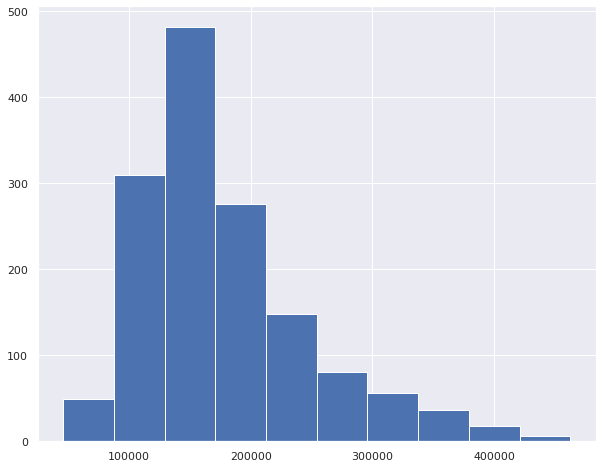

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
plt.figure(figsize=(10,8))
test['SalePrice'].hist();

In [38]:
test.rename(columns={'id': 'Id'}, inplace=True)

In [39]:
submission_path = "submission/house_prices_submission/"

In [40]:
test[['Id', 'SalePrice']].to_csv(submission_path+"fastai_house_prices_{0:.3f}.csv".format(cv_score), index=False)